This notebook demonstrates TensorFlow.js model conversion process for the [White-box Cartoonization](https://github.com/SystemErrorWang/White-box-Cartoonization) model proposed in [Learning to Cartoonize Using White-box Cartoon Representations](https://openaccess.thecvf.com/content_CVPR_2020/papers/Wang_Learning_to_Cartoonize_Using_White-Box_Cartoon_Representations_CVPR_2020_paper.pdf) (CVPR 2020) paper by Xinrui Wang and Jinze Yu.

Here's an example output from the [TensorFlow.js app](https://pratapvardhan.github.io/cartoonizer-with-tfjs/):

![demo](https://raw.githubusercontent.com/pratapvardhan/cartoonizer-with-tfjs/master/assets/demo.jpg)

[Try the web app](https://pratapvardhan.github.io/cartoonizer-with-tfjs/)

**Author**: [Pratap Vardhan](https://twitter.com/PratapVardhan)

**Acknowledgements**: 
- This notebook reproduces and borrows heavily from [Margaret Maynard-Reid](https://twitter.com/margaretmz), [Sayak Paul](https://twitter.com/RisingSayak)'s work on [TFLite model conversion](https://blog.tensorflow.org/2020/09/how-to-create-cartoonizer-with-tf-lite.html)
- Which relies on [Stefano Morelli](https://www.kaggle.com/steubk)'s on inference [scripts](https://github.com/steubk/White-box-Cartoonization/tree/inference-tf-2.x) and kaggle [kernel](https://www.kaggle.com/steubk/the-night-fellini-met-miyazaki).
- And, [White-box Cartoonization](https://github.com/SystemErrorWang/White-box-Cartoonization) repository from the original authors.

In [1]:
!git clone --branch inference-tf-2.x https://github.com/steubk/White-box-Cartoonization.git
!pip install --upgrade tf_slim

Cloning into 'White-box-Cartoonization'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 63.41 MiB | 37.53 MiB/s, done.
Resolving deltas: 100% (64/64), done.
     |████████████████████████████████| 358kB 4.5MB/s 


In [2]:
import sys
sys.path.append('./White-box-Cartoonization/test_code')

import os
import matplotlib.pyplot as plt
import cartoonize

from PIL import Image

In [3]:
!mkdir -p ./source
!wget https://raw.githubusercontent.com/pratapvardhan/cartoonizer-with-tfjs/master/assets/messi-ronaldo.jpg  -O ./source/image.jpg

--2020-09-13 19:08:00--  https://raw.githubusercontent.com/pratapvardhan/cartoonizer-with-tfjs/master/assets/messi-ronaldo.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25992 (25K) [image/jpeg]
Saving to: ‘./source/image.jpg’

./source/image.jpg  100%[===================>]  25.38K  --.-KB/s    in 0.006s  

2020-09-13 19:08:00 (4.03 MB/s) - ‘./source/image.jpg’ saved [25992/25992]



Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


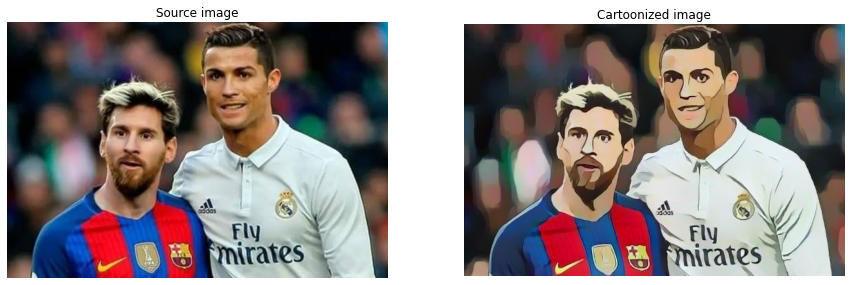

In [4]:
model_path = './White-box-Cartoonization/test_code/saved_models'
load_folder = './source'
save_folder = './cartoonized_images'
if not os.path.exists(save_folder): os.mkdir(save_folder)

cartoonize.cartoonize(load_folder, save_folder, model_path)
source_image = plt.imread('./source/image.jpg')
cartoonized_image = plt.imread('./cartoonized_images/image.jpg')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(source_image)
ax[0].set_title('Source image')
ax[1].imshow(cartoonized_image)
ax[1].set_title('Cartoonized image')
[x.set_axis_off() for x in ax]
plt.show()

In [5]:
# Directory where SavedModel is to be saved
!mkdir -p models/CartoonGAN/saved_model

In [6]:
# Comes with the GitHub repo
# These will be needed to instantiate the model
import network
import guided_filter

In [7]:
# We will be using TensorFlow session
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [8]:
tf.__version__

'2.3.0'

In [9]:
tf.reset_default_graph()
  
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
  # Create placeholder for the input
  input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name='input_photo')
  
  # Run the input placeholder through the generator, and then apply a 
  # filter to process the generator output
  network_out = network.unet_generator(input_photo)
  final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)
  final_out = tf.identity(final_out, name='final_output') # Create an identical filtering layer 
 
  # The above process is basically needed to construct the computation graph for the
  # current session
  
  # Get the generator variables and restore the pre-trained checkpoints in the 
  # current session
  all_vars = tf.trainable_variables()
  gene_vars = [var for var in all_vars if 'generator' in var.name]
  saver = tf.train.Saver(var_list=gene_vars)
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, tf.train.latest_checkpoint(model_path))
  
  # Export to SavedModel
  tf.saved_model.simple_save(
      sess,
      '/content/models/CartoonGAN/saved_model',
      inputs={input_photo.name: input_photo},
      outputs={final_out.name: final_out})

INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/models/CartoonGAN/saved_model/saved_model.pb


In [10]:
ls -lah models/CartoonGAN/saved_model

total 152K
drwxr-xr-x 3 root root 4.0K Sep 13 19:08 ./
drwxr-xr-x 3 root root 4.0K Sep 13 19:08 ../
-rw-r--r-- 1 root root 137K Sep 13 19:08 saved_model.pb
drwxr-xr-x 2 root root 4.0K Sep 13 19:08 variables/


## TensorFlow.js conversion

In [11]:
# Install tensorflowjs for tensorflowjs_converter
!pip install tensorflowjs --quiet

     |████████████████████████████████| 71kB 4.0MB/s 
     |████████████████████████████████| 137.3MB 79kB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 256kB 48.6MB/s 
     |████████████████████████████████| 952kB 41.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [12]:
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web

2020-09-13 19:08:34.743562: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-09-13 19:08:34.747405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-09-13 19:08:34.747650: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2928f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-13 19:08:34.747691: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items d

**Quantize the weights (Float 16)**

In [13]:
!tensorflowjs_converter --quantize_float16 \
    --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web-float16

2020-09-13 19:08:38.438095: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-09-13 19:08:38.442005: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-09-13 19:08:38.442252: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x19c6f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-13 19:08:38.442289: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items d

**Quantize the weights (unit 8)**

In [14]:
!tensorflowjs_converter --quantize_uint8 \
    --input_format=tf_saved_model --output_node_names='final_output' \
    models/CartoonGAN/saved_model models/CartoonGAN/web-uint8

2020-09-13 19:08:42.129019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-09-13 19:08:42.133013: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200000000 Hz
2020-09-13 19:08:42.133263: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2190f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-13 19:08:42.133300: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items d

Check model sizes

In [15]:
!du -sh models/CartoonGAN/*

5.8M	models/CartoonGAN/saved_model
5.7M	models/CartoonGAN/web
2.9M	models/CartoonGAN/web-float16
1.5M	models/CartoonGAN/web-uint8


Download models

In [ ]:
!zip -r models.zip models

In [ ]:
from google.colab import files
files.download('models.zip')